In [ ]:
print('Connect to google drive')
from google.colab import drive
drive.mount('/gdrive')

Connect to google drive
Mounted at /gdrive


In [ ]:
print('Import necessary libraries')

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import glob
import pickle

import warnings
warnings.filterwarnings("ignore")

import random
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
import gc
import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

import joblib

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler


Import necessary libraries


In [ ]:
base_path='/gdrive/My Drive/Colab Notebooks/'
weights_path='/gdrive/My Drive/Colab Notebooks/weights/'

In [ ]:
def euclidean_distance(x_true,y_true, x_pred, y_pred):
    return np.mean(((x_true-x_pred)**2+(y_true-y_pred)**2)**0.5)    

In [ ]:
version='forPdata423_halfgrid'


In [ ]:
data=pd.read_csv('/gdrive/My Drive/Colab Notebooks/data423.csv.zip') #
data.shape

(14373, 316)

In [ ]:
data.head()

,rsid1,rsid2,rsid3,rsid4,rsid5,rsid6,rsid7,rsid8,rsid9,rsid10,...,rsid307,rsid308,rsid309,rsid310,rsid311,rsid312,x,y,timestamp,path
0,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02
1,-93,-999,-81,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02
2,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02
3,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02
4,-78,-999,-999,-95,-999,-999,-999,-999,-999,-999,...,-999,-999,-999,-999,-999,-999,40.85,25.74,1633934473508,record_2021_10_11_07_41_02


In [ ]:
uniquePoints=data.loc[data.loc[:,['x','y']].duplicated()==False,['x','y']]
print('we have a target grid of',uniquePoints.shape[0],'unique points')

# sets divided in forPdata423_halfgrid_KNeighbors_wifis_position.ipynb
set1=[85,79,77,68,32,30,28,70,83,80,82,72,8,6,4,26,23,25,21,19,51,33,0,2,62,60,58,56,74,10,53,49,47,65,13,34,46,36,38,15,45,17,41,18]
set2=[84,78,86,67,69,31,29,27,71,81,73,76,7,5,3,24,9,22,20,50,64,1,63,61,59,57,55,52,54,11,48,12,66,75,14,35,37,39,16,40,42,44,43]

uniquePoints['pointNum']=np.arange(len(uniquePoints))
uniquePoints['setNum']=1
uniquePoints.setNum.iloc[set2]=2

data=data.merge(uniquePoints,left_on=['x','y'],right_on=['x','y'])

we have a target grid of 87 unique points


In [ ]:
# print('split path-timestamp in 2 columns')
# data[['path','timestamp']]=data['path-timestamp'].str.split('-',expand=True)
# print('remove path-timestamp column')
# data.drop('path-timestamp', axis=1,inplace=True)

In [ ]:
# data.head()

In [ ]:
num_of_lines=len(data)
data2=[]
for i in range(num_of_lines):
    if i % 1000 == 0:
        print(f'current:{i}')

    tmp=data.iloc[i,:-6].astype(int).reset_index(drop=False)
    # tmp=data.iloc[i,:-4].astype(int).reset_index(drop=False)
    tmp.columns=['BSSID','Signal_Strength']
    tmp=tmp.sort_values(['Signal_Strength', 'BSSID'],ascending=False)
    target = data.iloc[i,-6:]
    # target = data.iloc[i,-4:]

    line = pd.concat([pd.Series(tmp.BSSID.astype(str)), tmp.Signal_Strength.astype(int), target])

    line.index = [str(i) for i in range(2*len(tmp)+6)]
    # line.index = [str(i) for i in range(2*len(tmp)+4)]

    data2.append(line.values)
data2 = pd.DataFrame(np.stack(data2))

# data2.columns = [f'BSSID{str(i)}' for i in range(len(tmp))] + [f'Signal_Strength_{str(i)}' for i in range(len(tmp))] + ['x','y', 'timestamp', 'path']
data2.columns = [f'BSSID{str(i)}' for i in range(len(tmp))] + [f'Signal_Strength_{str(i)}' for i in range(len(tmp))] + ['x','y', 'timestamp', 'path', 'pointNum', 'setNum']
# data.to_csv(SAVEDIR+file_name, index=False)



current:0
current:1000
current:2000
current:3000
current:4000
current:5000
current:6000
current:7000
current:8000
current:9000
current:10000
current:11000
current:12000
current:13000
current:14000


In [ ]:
target

x                                 49.69
y                                 42.48
timestamp                 1634883819291
path         record_2021_10_22_07_23_13
pointNum                             86
setNum                                2
Name: 14372, dtype: object

In [ ]:
data=data2.copy()

In [ ]:
data.head()

,BSSID0,BSSID1,BSSID2,BSSID3,BSSID4,BSSID5,BSSID6,BSSID7,BSSID8,BSSID9,...,Signal_Strength_308,Signal_Strength_309,Signal_Strength_310,Signal_Strength_311,x,y,timestamp,path,pointNum,setNum
0,rsid34,rsid33,rsid32,rsid30,rsid29,rsid31,rsid145,rsid144,rsid146,rsid92,...,-999,-999,-999,-999,43.26,25.89,1633934464983,record_2021_10_11_07_41_02,0,1
1,rsid34,rsid33,rsid32,rsid30,rsid29,rsid31,rsid145,rsid144,rsid146,rsid92,...,-999,-999,-999,-999,43.26,25.89,1633934467125,record_2021_10_11_07_41_02,0,1
2,rsid32,rsid34,rsid33,rsid29,rsid91,rsid90,rsid145,rsid146,rsid144,rsid95,...,-999,-999,-999,-999,43.26,25.89,1633934469251,record_2021_10_11_07_41_02,0,1
3,rsid32,rsid34,rsid33,rsid29,rsid91,rsid90,rsid145,rsid146,rsid144,rsid95,...,-999,-999,-999,-999,43.26,25.89,1633934471370,record_2021_10_11_07_41_02,0,1
4,rsid32,rsid34,rsid33,rsid29,rsid146,rsid145,rsid144,rsid90,rsid225,rsid304,...,-999,-999,-999,-999,43.26,25.89,1633934490489,record_2021_10_11_07_41_02,0,1


In [ ]:
data.shape

(14373, 630)

In [ ]:
a=data.loc[:,[x for x in data.columns if x.startswith('Signal_Strength')]].max().values
MAX_NUM_WIFIS=np.where(a[a>-999])[0].max()
MAX_NUM_WIFIS

86

In [ ]:
BSSID_FEATS=[x for x in data.columns if x.startswith('BSSID')]
RSSI_FEATS=[x for x in data.columns if x.startswith('Signal_Strength')]

len(BSSID_FEATS),len(RSSI_FEATS)

(312, 312)

In [ ]:

wifi_bssids = []
for i in range(len(BSSID_FEATS)):
    wifi_bssids.extend(data.iloc[:,i].values.tolist())
wifi_bssids = list(set(wifi_bssids))

wifi_bssids = np.unique(wifi_bssids)
wifi_bssids_size = len(wifi_bssids)
print(wifi_bssids_size)

wifi_bssids_dict={}
counter = 0               #<-------------  1 not 0
for wf in wifi_bssids:
    wifi_bssids_dict[wf]=counter
    counter+=1
# import joblib
# joblib.dump(wifi_bssids_dict,'wifi_bssids_dict2')    

312


In [ ]:
# for i in BSSID_FEATS[:MAX_NUM_WIFIS]:
for i in BSSID_FEATS:
    data.loc[:,i] = data.loc[:,i] .apply(lambda x: wifi_bssids_dict[x])

In [ ]:
data.loc[:,BSSID_FEATS[:MAX_NUM_WIFIS]]=data.loc[:,BSSID_FEATS[:MAX_NUM_WIFIS]].astype('float32')

In [ ]:
Ms=np.mean(data.loc[:,RSSI_FEATS[:MAX_NUM_WIFIS]].values.astype('float32'),axis=0)
Ss=np.std(data.loc[:,RSSI_FEATS[:MAX_NUM_WIFIS]].values.astype('float32'),axis=0)
# joblib.dump(Ms,'means_of_rssids2')
# joblib.dump(Ss,'stds_of_rssids2')
Ms[:5],Ss[:5]

(array([-51.815975, -53.653725, -54.69721 , -57.28261 , -60.02574 ],
       dtype=float32),
 array([6.1781244, 6.213863 , 6.278394 , 5.7653995, 6.2344913],
       dtype=float32))

In [ ]:
for i in range(MAX_NUM_WIFIS):
    data.loc[:,RSSI_FEATS[i]] = ((data.loc[:,RSSI_FEATS[i]] - Ms[i])/(Ss[i]+1)).astype('float32')

In [ ]:
data.loc[:,RSSI_FEATS].head()

,Signal_Strength_0,Signal_Strength_1,Signal_Strength_2,Signal_Strength_3,Signal_Strength_4,Signal_Strength_5,Signal_Strength_6,Signal_Strength_7,Signal_Strength_8,Signal_Strength_9,...,Signal_Strength_302,Signal_Strength_303,Signal_Strength_304,Signal_Strength_305,Signal_Strength_306,Signal_Strength_307,Signal_Strength_308,Signal_Strength_309,Signal_Strength_310,Signal_Strength_311
0,1.228173,1.476840,1.469721,1.372072,1.662279,1.674138,0.631045,0.83145,0.660995,-0.020929,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,1.228173,1.476840,1.469721,1.372072,1.662279,1.674138,0.631045,0.83145,0.660995,-0.020929,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,1.785421,1.615462,1.607114,0.189584,-0.964029,-0.793490,-0.633178,-0.59369,-0.445404,-0.193712,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,1.785421,1.615462,1.607114,0.189584,-0.964029,-0.793490,-0.633178,-0.59369,-0.445404,-0.193712,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,1.646109,1.199597,1.194935,0.633017,-1.240482,-1.067671,-1.107262,-1.86048,-2.025973,-0.769654,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [ ]:
dataA=data.copy()

In [ ]:
# TRAIN_FEATS=[x for x in data.columns if x not in ['x', 'y', 'path', 'timestamp']]
# len(TRAIN_FEATS)

In [ ]:
# d2=data.loc[:,TRAIN_FEATS].copy()
# d2[d2==-999]=0
# d2[d2!=0]=1

In [ ]:
# d2.head()

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist(np.sum(d2,0),50)
# plt.show()

In [ ]:

# Ms=np.mean(data.loc[:,TRAIN_FEATS].values,axis=0)
# Ss=np.std(data.loc[:,TRAIN_FEATS].values,axis=0)

# # joblib.dump(Ms,'means_of_rssids2')
# # joblib.dump(Ss,'stds_of_rssids2')

# for i in range(len(TRAIN_FEATS)):
#     data.loc[:,TRAIN_FEATS[i]] = (data.loc[:,TRAIN_FEATS[i]] - Ms[i])/(Ss[i]+1)

In [ ]:
unpaths=data.path.unique()

In [ ]:
print('we have ',len(unpaths),' unique paths')

we have  423  unique paths


In [ ]:
# USE_FEATS=TRAIN_FEATS[:]
# # USE_FEATS=np.array(TRAIN_FEATS)[np.where((np.sum(d2,0))>200)[0]]
# USE_FEATS.shape

### CV TRAIN

In [ ]:

def create_model(bssid_size1, rssi_size):

    def myFunc(x,size=bssid_size1):
        return x[:,:size]
    def myFunc2(x,size=bssid_size1):
        return x[:,size:]
            
    input_layer_all = L.Input(shape=(bssid_size1+ rssi_size,), name='inputL', dtype='float32')
    # input_layer_all = L.Dropout(0.1, name='do1')(input_layer_all)    
    input_embd_layer = L.Lambda(myFunc )(input_layer_all)
    x1 = L.Embedding(wifi_bssids_size, 4, name='emb_bssid')(input_embd_layer)
#     x1 = L.Dropout(0.1)(x1)
    x1 = L.Flatten( name='fl_bssid')(x1)
    # print(x1.shape)
    
    
    # rssi feats
    # input_layer = L.Input((rssi_size, ), name='input_rsid', dtype='float32')
    input_layer = L.Lambda(myFunc2)(input_layer_all)
    x2 = L.BatchNormalization(name='bn1')(input_layer)
    x2 = L.Dense(rssi_size * 1, name='dn1')(x2)
    x2 = L.Dropout(0.1, name='do1')(x2)    
#     x2 = L.Dense(NUM_FEATS * 4, activation='relu')(x2)
    # print(x2.shape)
    

    
    # main stream
    x = L.Concatenate(axis=1, name='concat')([x1, x2])
    # print(x.shape)
#     x = L.Flatten()(x)
    x = L.BatchNormalization(name='bn2')(x)
    x = L.Dropout(0.5, name='do2')(x)
    x = L.Dense(256, name='dn2')(x)
#     x = L.Dropout(0.1)(x)
#     x = L.Dense(256, activation='relu')(x)

    x = L.Reshape((1 , 256), name='resh')(x)
#     x = L.Reshape((1 , -1))(x)
    # print(x.shape)
    x = L.BatchNormalization(name='bn3')(x)
    x = L.LSTM(128, return_sequences=True, name='lstm1')(x)
    x = L.Dropout(0.2, name='do3')(x)
    x = L.BatchNormalization(name='bn4')(x)    
    x = L.LSTM(64, return_sequences=True, name='lstm2')(x)
    x = L.Dropout(0.2, name='do4')(x)
#     x = L.Bidirectional(L.LSTM(512, return_sequences=True))(x)
#     x = L.BatchNormalization()(x)    
#     x = L.Bidirectional(L.LSTM(256, return_sequences=True))(x)    
    x = L.BatchNormalization(name='bn5')(x)
    x = L.LSTM(32, return_sequences=False, name='lstm3')(x)
    # x = L.LSTM(128, return_sequences=False, name='lstm3')(x)
#     x = L.Dropout(0.1)(x)
    # print(x.shape)
    
    
    
    x = L.BatchNormalization(name='bn6')(x)
#     x = L.Dropout(0.1)(x)
#     x = L.Dense(64)(x)
# #     x = L.Dropout(0.1)(x)
#     x = L.Dense(128)(x)
# #     x = L.Dense(64, activation='relu')(x)

    
    
    output_layer_1 = L.Dense(2, name='xy')(x)
#     output_layer_2 = L.Dense(1, activation='softmax', name='floor')(x)

    model = M.Model(inputs=input_layer_all, 
#     model = M.Model([input_embd_layer, input_embd_layerb, input_layer, input_site_layer], 
                    outputs=output_layer_1)
#                     [output_layer_1, output_layer_2])

    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                  loss='mse', metrics=['mse'])

    return model    
model =  create_model(bssid_size1=MAX_NUM_WIFIS, rssi_size=MAX_NUM_WIFIS )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputL (InputLayer)            [(None, 172)]        0           []                               
                                                                                                  
 lambda_1 (Lambda)              (None, 86)           0           ['inputL[0][0]']                 
                                                                                                  
 lambda (Lambda)                (None, 86)           0           ['inputL[0][0]']                 
                                                                                                  
 bn1 (BatchNormalization)       (None, 86)           344         ['lambda_1[0][0]']               
                                                                                              

In [ ]:
def _cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // snapshots))
    cos_inner /= epochs // snapshots
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)

In [ ]:
NUM_FEATS=MAX_NUM_WIFIS
NUM_FEATS

86

In [ ]:
# data.loc[:, ['x', 'y'] ]=data.loc[:, ['x', 'y'] ].values.astype('float32')
# data.loc[:, ['x'] ]=data.loc[:, ['x'] ].values.astype('float32')
# data.loc[:, ['y'] ]=data.loc[:, ['y'] ].values.astype('float32')
# data.x=data.x.values.astype('float32')
# data.y=data.y.values.astype('float32')
# data.loc[:, ['x', 'y'] ].dtypes
dataA.x=dataA.x.values.astype('float32')
dataA.y=dataA.y.values.astype('float32')
dataA.loc[:, ['x', 'y'] ].dtypes

x    float32
y    float32
dtype: object

In [ ]:
# X_train.min().values

In [ ]:
# X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].astype('float32').values
# X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values
# X_train.loc[:,RSSI_FEATS[NUM_FEATS-1]].values
# np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1).shape
# np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1).max()
# data.loc[:, ['x', 'y'] ].reset_index(drop=True).values

In [ ]:
NUM_FEATS=60

In [ ]:
# CROSS VALIDATION

name='keras'+version

split_score=[]
for split in [1,2]:
    data=dataA.loc[dataA.setNum==split,:]
    data.shape
    unpaths=data.path.unique()
    print('we have ',len(unpaths),' unique paths')
    
    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)

        X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)

        y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)
        y_val = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
        epochs=140
        snapshots = 7
        lr_0 = 0.01
        lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

        h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_train, 
                    batch_size=128*8, epochs=epochs, verbose=1,
                    validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_val),
                    callbacks=[ lr_anneal1])
            
        epochs=140
        snapshots = 7
        lr_0 = 0.001
        lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

        h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_train, 
                    batch_size=128*8, epochs=epochs, verbose=1,
                    validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
                    y_val),
                    callbacks=[ lr_anneal1])

        # model.save_weights(weights_path+name+'_fold'+str(f)+'.hdf5')
        model.save_weights(weights_path+name+'split'+str(split)+'_fold'+str(f)+'.hdf5')
        val_predsXY = model.predict(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1)) 

        
        print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_val[:,0], y_val[:,1]))

        all_preds.append(val_predsXY)
        all_targets.append(y_val)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    

    print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    split_score.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
print('average splits score', np.mean(split_score))   

In [ ]:
print('mean validation error, 5-fold', split_score,np.mean(split_score))

mean validation error, 5-fold [1.8967295, 1.9454861] 1.9211078


In [ ]:
pd.DataFrame(all_predsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_oof2_again.csv.gz', index=False, compression='gzip')
# pd.DataFrame(all_targetsV,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/all_targetsV.csv.gz', index=False, compression='gzip')

In [ ]:
print('mean validation error, 5-fold', split_score,np.mean(split_score))

mean validation error, 5-fold [1.8712686, 1.9394412] 1.905355


In [ ]:
# CROSS VALIDATION

name='keras'+version


split_score=[]
split_score_othersplit=[]
for split in [1,2]:
    data=dataA.loc[dataA.setNum==split,:]
    data_other_split = dataA.loc[dataA.setNum==(3-split),:]
    unpaths_other_split=data_other_split.path.unique()
    data.shape
    unpaths=data.path.unique()
    print('we have ',len(unpaths),' unique paths')
    score_df = pd.DataFrame()
    oof = list()
    predictions = list()

    oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
    preds_x, preds_y = 0, 0

    oof_x_othersplit, oof_y_othersplit = np.zeros(data_other_split.shape[0]), np.zeros(data_other_split.shape[0])
    preds_x_othersplit, preds_y_othersplit = 0, 0

    scores_per_fold=[]

    all_preds=[]
    all_targets=[]
    all_preds_othersplit=[]
    all_targets_othersplit=[]

    np.random.seed(42)
    sh=np.random.permutation(unpaths)


    k=5
    val_size=int(len(sh)/k)
    for f in range(k):
        print('fold:', f)

        if f<(k-1):
            val_paths=sh[val_size*f:val_size*(f+1)]
        else:
            val_paths=sh[val_size*f:]

        train_paths=[x for x in unpaths if x not in val_paths]
        
        val_paths=np.array(val_paths)
        train_paths=np.array(train_paths)
        
        # X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)

        # y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

        X_val = data.loc[data.path.isin(val_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)
        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


        y_valXY = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values

        # val_paths = np.concatenate((val_paths,unpaths_other_split))
        # X_val = dataA.loc[dataA.path.isin(val_paths), TRAIN_FEATS ].reset_index(drop=True)
        # y_valXY = dataA.loc[dataA.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values
        
        X_val_othersplit = data_other_split.loc[:, BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)
        y_valXY_othersplit = data_other_split.loc[:, ['x', 'y'] ].reset_index(drop=True).values


        val_predsXY=[]
        val_predsXY_othersplit=[]
        

        model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
        model.load_weights(weights_path+name+'split'+str(split)+'_fold'+str(f)+'.hdf5')

        val_predsXY = model.predict(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1))
        val_predsXY_othersplit = model.predict(np.concatenate((X_val_othersplit.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val_othersplit.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1))

        
        print(euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_valXY[:,0], y_valXY[:,1]))
        print(euclidean_distance(val_predsXY_othersplit[:,0], val_predsXY_othersplit[:,1], y_valXY_othersplit[:,0], y_valXY_othersplit[:,1]))

        all_preds.append(val_predsXY)
        all_preds_othersplit.append(val_predsXY_othersplit)
        all_targets.append(y_valXY)
        all_targets_othersplit.append(y_valXY_othersplit)
            

    all_predsV=np.vstack(all_preds)
    all_targetsV=np.vstack(all_targets)    

    all_predsV_othersplit=np.vstack(all_preds_othersplit)
    all_targetsV_othersplit=np.vstack(all_targets_othersplit)    

    print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    split_score.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
    print('mean validation error othersplit, 5-fold', euclidean_distance(all_targetsV_othersplit[:,0], all_targetsV_othersplit[:,1], all_predsV_othersplit[:,0], all_predsV_othersplit[:,1]))
    split_score_othersplit.append(euclidean_distance(all_targetsV_othersplit[:,0], all_targetsV_othersplit[:,1], all_predsV_othersplit[:,0], all_predsV_othersplit[:,1]))
print('average splits score', np.mean(split_score))       
print('average splits othersplit score', np.mean(split_score_othersplit))       

we have  423  unique paths
fold: 0
1.9744097
2.528142
fold: 1
1.9047594
2.4771323
fold: 2
2.0124338
2.4986382
fold: 3
1.7879307
2.5185437
fold: 4
1.8378246
2.5043886
mean validation error, 5-fold 1.8967295
mean validation error othersplit, 5-fold 2.5053687
we have  423  unique paths
fold: 0
1.9465185
2.407889
fold: 1
2.0541325
2.4383385
fold: 2
1.9736674
2.43881
fold: 3
1.8388749
2.434107
fold: 4
1.908368
2.4362402
mean validation error, 5-fold 1.9454861
mean validation error othersplit, 5-fold 2.431077
average splits score 1.9211078
average splits othersplit score 2.4682229


In [ ]:
( np.mean(split_score)+np.mean(split_score_othersplit))/2
# 2.1946654319763184

2.1946654319763184

In [ ]:
pd.DataFrame(all_predsV_othersplit,columns=['x', 'y']).to_csv('/gdrive/My Drive/Colab Notebooks/'+name+'_othersplit_oof2.csv.gz', index=False, compression='gzip')

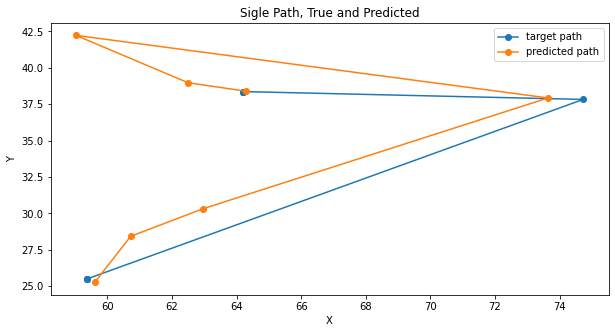

In [ ]:
# unp=data.path.unique()
import matplotlib.pyplot as plt
# ind=np.array(data.loc[data.path==unp[1],:].index)
X_val2 = data.loc[data.path.isin(val_paths),:].reset_index(drop=True)
ind=np.array(X_val2.loc[X_val2.path==val_paths[8],:].index)
plt.figure(figsize=(10,5))
plt.title('Sigle Path, True and Predicted')

# plt.plot(data.x.iloc[ind].values,data.y.iloc[ind].values,'-.')
plt.plot(all_targetsV[ind,0], all_targetsV[ind,1],'-o',label='target path')
plt.plot(all_predsV[ind,0], all_predsV[ind,1],'-o',label='predicted path')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# for NUM_FEATS in range(46,87,4):
    

In [ ]:
# # CROSS VALIDATION

# name='keras'+version


# np.random.seed(42)
# sh=np.random.permutation(unpaths)

# k=5
# val_size=int(len(sh)/k)
# alls=[]
# for NUM_FEATS in range(46,87,4):
#     print(NUM_FEATS)


#     score_df = pd.DataFrame()
#     oof = list()
#     predictions = list()

#     oof_x, oof_y = np.zeros(data.shape[0]), np.zeros(data.shape[0])
#     preds_x, preds_y = 0, 0

#     scores_per_fold=[]

#     all_preds=[]
#     all_targets=[]

#     for f in range(k):
#         print('fold:', f)

#         if f<(k-1):
#             val_paths=sh[val_size*f:val_size*(f+1)]
#         else:
#             val_paths=sh[val_size*f:]

#         train_paths=[x for x in unpaths if x not in val_paths]
        
#         val_paths=np.array(val_paths)
#         train_paths=np.array(train_paths)

#         X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)

#         y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

#         X_val = data.loc[data.path.isin(val_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)
#         y_val = data.loc[data.path.isin(val_paths), ['x', 'y'] ].reset_index(drop=True).values


#         model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
#         epochs=100
#         snapshots = 5
#         lr_0 = 0.01
#         lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

#         h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                     y_train, 
#                     batch_size=128*8, epochs=epochs, verbose=0,
#                     validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                     y_val),
#                     callbacks=[ lr_anneal1])
            
#         epochs=100
#         snapshots = 5
#         lr_0 = 0.001
#         lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

#         h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                     y_train, 
#                     batch_size=128*8, epochs=epochs, verbose=0,
#                     validation_data=(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                     y_val),
#                     callbacks=[ lr_anneal1])

#         model.save_weights(weights_path+name+'_fold'+str(f)+'.hdf5')
#         val_predsXY = model.predict(np.concatenate((X_val.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_val.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1)) 

        
#         print(f,euclidean_distance(val_predsXY[:,0], val_predsXY[:,1], y_val[:,0], y_val[:,1]))

#         all_preds.append(val_predsXY)
#         all_targets.append(y_val)
            

#     all_predsV=np.vstack(all_preds)
#     all_targetsV=np.vstack(all_targets)    

#     alls.append(euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))
#     print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
name

'kerasforPdata423_halfgrid'

In [ ]:
# plt.plot(np.array(alls))
# plt.show()

In [ ]:
l=pd.read_csv('/gdrive/My Drive/Colab Notebooks/lgbmforPdata423_halfgrid_oof2.csv.gz')

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], l.x.values, l.y.values)

1.9088333672086173

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], (l.x.values+all_predsV[:,0])/2, (l.y.values+all_predsV[:,1])/2)

1.829003251059625

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], (2*l.x.values+all_predsV[:,0])/3, (2*l.y.values+all_predsV[:,1])/3)

1.8368859784158909

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], (1.5*l.x.values+all_predsV[:,0])/2.5, (1.5*l.y.values+all_predsV[:,1])/2.5)

1.8315101041700848

In [ ]:
euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], (l.x.values*all_predsV[:,0])**0.5, (l.y.values*all_predsV[:,1])**0.5)

1.8287795461310454

## EVALUATION - PLOTS

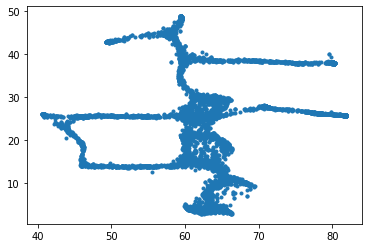

In [ ]:
import matplotlib.pyplot as plt
plt.plot(all_predsV[:,0],all_predsV[:,1],'.')
plt.show()

**5 FOLD CV PREDICTIONS OVER TARGET GRID**  
With blue dots are the true checkpoints  
Orange dots for predictions

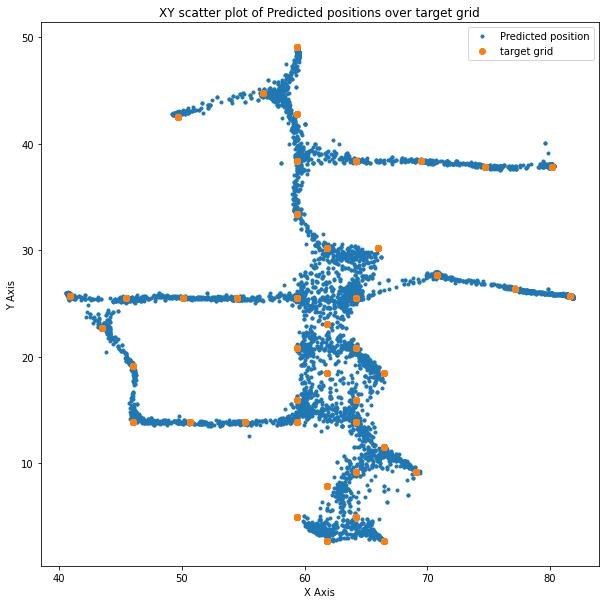

mean validation error, 5-fold 1.9394412


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_predsV[:,0],all_predsV[:,1],'.', label='Predicted position')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', label='target grid')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

In [ ]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], all_predsV[row,0], all_predsV[row,1]))

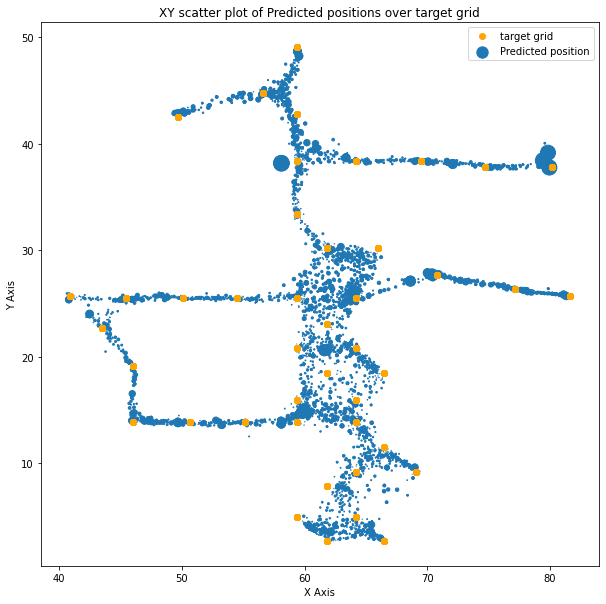

mean validation error, 5-fold 1.9394412


In [ ]:
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter(all_predsV[:,0],all_predsV[:,1],s=0.5*np.array(scoreperrow)**2, label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()
print('mean validation error, 5-fold', euclidean_distance(all_targetsV[:,0], all_targetsV[:,1], all_predsV[:,0], all_predsV[:,1]))

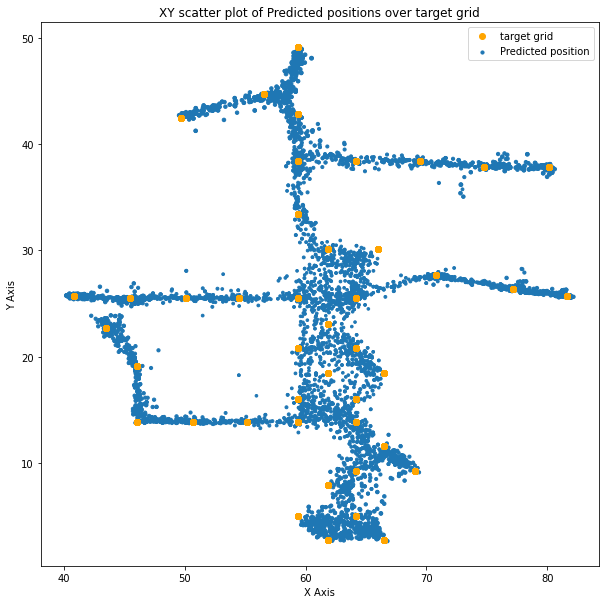

In [ ]:
scoreperrow=[]
for row in range(len(all_targetsV)):
    scoreperrow.append(euclidean_distance(all_targetsV[row,0], all_targetsV[row,1], (l.x.values+all_predsV[:,0])/2, (l.y.values+all_predsV[:,1])/2))
    
plt.figure(figsize=(10,10))
plt.title('XY scatter plot of Predicted positions over target grid')
plt.plot(all_targetsV[:,0],all_targetsV[:,1],'o', color="orange", label='target grid')
plt.scatter((l.x.values+all_predsV[:,0])/2, (l.y.values+all_predsV[:,1])/2,s=0.5*np.array(scoreperrow), label='Predicted position')
plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.show()

## Full train

In [ ]:


# name='keras'+version

# train_paths=unpaths[:]

# train_paths=np.array(train_paths)
# X_train = data.loc[data.path.isin(train_paths), BSSID_FEATS + RSSI_FEATS ].reset_index(drop=True)#.values

# y_train =  data.loc[data.path.isin(train_paths), ['x', 'y'] ].reset_index(drop=True).values

# model = create_model(bssid_size1=NUM_FEATS, rssi_size=NUM_FEATS  )
# epochs=160
# snapshots = 8
# lr_0 = 0.01
# lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

# h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                   y_train, 
#                   batch_size=128*8, epochs=epochs, verbose=1,
#                 callbacks=[ lr_anneal1])

# epochs=160
# snapshots = 8
# lr_0 = 0.001
# lr_anneal1 = LearningRateScheduler(schedule=_cosine_anneal_schedule, verbose=False)

# h = model.fit(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1),
#                   y_train, 
#                   batch_size=128*8, epochs=epochs, verbose=1,
#                 callbacks=[ lr_anneal1])
# model.save_weights(weights_path+name+'_full'+'.hdf5')
# train_predsXY = model.predict(np.concatenate((X_train.loc[:,BSSID_FEATS[:NUM_FEATS]].values, X_train.loc[:,RSSI_FEATS[:NUM_FEATS]].values),1))


# print('train error',euclidean_distance(train_predsXY[:,0], train_predsXY[:,1], y_train[:,0], y_train[:,1]))
